# Diffuse Fit Workshop #

Manuel Silva and Ibrahim Safa

June 14, 2019

\\

*Many thanks to Austin for providing the dataset and helping us put this exercise together!*


# Prepare the Environment #
* You need all these packages to play around with the data
* [numpy](https://www.numpy.org/) and [scipy](https://www.scipy.org/) are for managing and analyzing the data 
* [matplotlib](https://matplotlib.org/) is good for making plots and visualizing data
* [json](https://pythonbasics.org/json/) is a data structure for storing and sharing data
* Start by importing them!

\\
*if you are not too familiar with these packages, make sure to follow the links and look at some examples

In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import json

# Download the dataset #
* Start by downloading the dataset to your machine
  * https://icecube.wisc.edu/~msilva/BootCamp_2019/toy_data.tar.gz
* If you aren't sure how to extract tarbells, copy and paste the following line:
  * tar -xzvf toy_data.tar.gz
* Make sure "hese_toy_data.json" and "hese_toy_simulation.json" can now be accessed on your machine

# Load the Simulation (eg expectation) #
* The dataset was saved as a json file
* In the real world, you might use ".i3", ".npy", ".pkl" datasets
  * Follow the example below, for loading the simulation dataset
  
* It is always a good idea to "print" every few lines and make sure the dataset is properly loaded into your python session


In [5]:
json_contents = json.load(open('./hese_toy_simulation.json', "r"))
simulation_mapping = json_contents["mapping"]
simulation_events = np.array(json_contents["events"])
del json_contents

In [6]:
sim_map = sorted(simulation_mapping.items(), key=lambda x: x[1])
print (sim_map)

[('astroWeight', 0), ('atmoWeight', 1), ('energy', 2), ('primaryEnergy', 3), ('primaryZenith', 4), ('topology', 5), ('zenith', 6)]


In [7]:
print (simulation_events[:2])
[[(k, e[i]) for k, i in sim_map] for e in simulation_events[:2]]

[[1.455e-05 9.797e-06 1.007e+05 1.391e+05 1.581e+00 0.000e+00 1.500e+00]
 [7.289e-06 4.587e-07 3.191e+05 2.485e+05 7.607e-01 0.000e+00 9.098e-01]]


[[('astroWeight', 1.455e-05),
  ('atmoWeight', 9.797e-06),
  ('energy', 100700.0),
  ('primaryEnergy', 139100.0),
  ('primaryZenith', 1.581),
  ('topology', 0.0),
  ('zenith', 1.5)],
 [('astroWeight', 7.289e-06),
  ('atmoWeight', 4.587e-07),
  ('energy', 319100.0),
  ('primaryEnergy', 248500.0),
  ('primaryZenith', 0.7607),
  ('topology', 0.0),
  ('zenith', 0.9098)]]

# Load the Data (eg observation) #
* Follow the same procedure to load the data
  * remember to change the variable names so you don't accidentally overwrite the simulation

In [9]:
json_contents = json.load(open('./hese_toy_data.json', "r"))
data_mapping = json_contents["mapping"]
data_events = np.array(json_contents["events"])
del json_contents

In [10]:
data_map = sorted(data_mapping.items(), key=lambda x: x[1])
print (data_map)

[('energy', 0), ('topology', 1), ('zenith', 2)]


In [11]:
print (data_events[:2])
[[(k, e[i]) for k, i in data_map] for e in data_events[:2]]

[[6.22225597e+04 0.00000000e+00 5.31069057e-01]
 [6.16774498e+04 0.00000000e+00 3.50297146e-01]]


[[('energy', 62222.55968669473),
  ('topology', 0.0),
  ('zenith', 0.5310690569408663)],
 [('energy', 61677.44976245666),
  ('topology', 0.0),
  ('zenith', 0.350297145700488)]]

# Computing the Expectation Value (eg $\lambda$) #

* Now let's run IceCube for 1 year, how many neutrinos do you expect to see?
  * what happens if we ask for number of neutrinos for energies > 100 TeV?
  * what about zeniths > 90?
* The best way to compute an expectation value is to use Monte Carlo (eg simulation)!
* Start by generating a bunch of neutrinos and "inject" them into IceCube
  * You usually inject neutrinos following some sort of energy distribution, zenith distribution, all azimuths, and over a certain area of IceCube (we inject directly inside IceCube, sometimes further away, sometimes deepcore only)

\\
* Since you can change the generated events by simply making a choice (maybe you want high energy neutrinos vs low energy neutrinos), we need to normalize the simulated events
  * Take your simulated events and assign a "weight" to every event, refer to this "weight" as a generated flux:
  
  $\Phi_{generated} = N_{generated} [GeV^{-1} * sr^{-1} * cm^{-2}]$
  
* You can now apply a theoretical model to your simulation to extract an expected flux for that particular simulation
  * Take 2 year MESE flux as an example, note the units
  
  $\Phi_{model} = \Phi_{MESE} = 2.06 *10^{-18}*(\frac{E_{\nu}}{100TeV})^{-2.46} [s^{-1} * GeV^{-1} * sr^{-1} * cm^{-2}]$
  
\\
* You can now combine the generated flux and theoretical fluxes to extract event rates
  * Each sample will now have it's own expectation rate in units $s^{-1}$
  * This is literally the expectation (weight) that IceCube "sees" an event exactly like this every second

  $w_{i} = \frac{\Phi_{model}}{\Phi_{generated}}$

* $w_{i}$ is the expectation value assuming a perfect detector with perfect simulation....this is not true though

# Apply Realistic Weights to the Simulation! #
* After taking into account your event selection, detector effects, etc.... an additional weight is taken into account

  $w_{i} = w*\frac{\Phi_{model}}{\Phi_{generated}}$
  
* Since the HESE dataset measures the astrophysical and atmospheric neutrino fluxes, we need to take both expectations into account

  $w_{i,atmos} = w_{atmos}*\frac{\Phi_{atmos}}{\Phi_{gen,atmos}}$,
  $w_{i,astro} = w_{astro}*\frac{\Phi_{astro}}{\Phi_{gen,astro}}$

  $w_{i,total} = w_{i,atmos} + w_{i,astro}$

\\
*  At this point, we are technically done computing our expecation value, but we do not really know if we should trust the simulation or the theoretical models
  * We need to introduce variations to the simulation, the easiest way to do this is to reweight the simulation
  

# Let's write some code now... #

* For the atmospheric component, we will add some overall normalization term ($N_{atmos}$)

  $w_{i,atmos}=N_{atmos}*w_{atmos}$

* For the astrophysical component, we will add some overall normalization term ($N_{astro}$) along with an additional energy spectral index term ($\gamma$)
  * scale your simulation by the following: $1.0⋅\frac{E_{\nu}}{100TeV}^{−2.5}$ 
  * why did we do this?

  $w_{i,astro}=N_{astro}* \frac{E_{\nu}}{100TeV}^{−\gamma}/ \frac{E_{\nu}}{100TeV}^{−2.5} * w_{astro}$
  
\\
* look at the simulation you loaded earlier (eg "print simulation_events")
##We gave you the weights!!##

* you want to takes these weights and rescales them to different $N_{atmos}$, $N_{astro}$, $\gamma$

* write a python function now 

def weight_event(event, atmos_norm, astro_norm, astro_gamma):

    fill in your code here

In [26]:
def weight_event(events, atmo_norm, astro_norm, astro_gamma):
    astro_weight = events[...,0]
    atmo_weight = events[...,1]
    primary_energy = events[...,3]
    weight = atmo_norm * atmo_weight + astro_norm * astro_weight * np.power(primary_energy / 1e5, -(astro_gamma - 2.5))
    return weight

# Bin the Data! #
* We can take all the HESE events and run a fit using the maximum likelihood technique you learned earlier today!
  * But remember, there are different detector effects for different energy ranges, zeniths, topologies, so we need to be a little more rigorous here!
*  Let's use energy, zenith, and topology as our observables and create some bins 

\\
*  Start by creating bins for different energy ranges
  *  The HESE dataset is primarily for high energy, E = [60 TeV, 10 PeV]
  *  Do you think log space or linear space is preferable?
*  Now create bins for different zenith ranges
  *  HESE is all sky, $\theta = [0, \pi]$
  *  Do you think we should bin in linear space, log space
  *  What about binning it in $\theta$ vs cos($\theta$)
*  HESE can theoretically measure three different topolgies, but for today lets stick to tracks vs cascades 
  * Create two bins for topology

\\

* Easiest way to create bins is by using "[numpy.logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html)" and "[numpy.linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html)"

In [27]:
energy_bins = np.logspace(np.log10(60.0e3), np.log10(1.0e7), 20+1)
zenith_bins = np.arccos(np.linspace(-1, 1, 10+1))[::-1]
topology_bins = np.linspace(0, 2, 2+1)

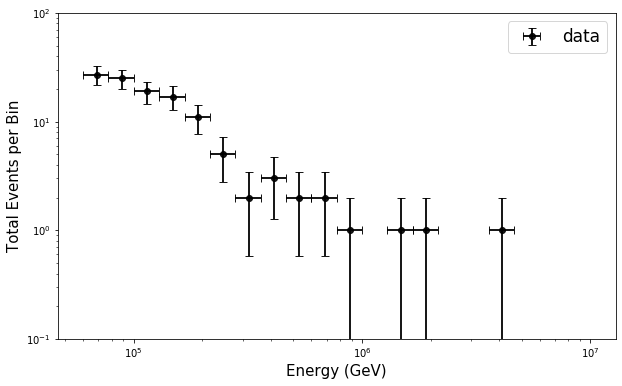

In [28]:
h = np.histogram(data_events[:,0], bins = energy_bins)
centers = (energy_bins[1:] + energy_bins[:-1])/2.
lower = centers - energy_bins[:-1] 
upper = energy_bins[1:] - centers
xerr = np.array([lower, upper])
yerr = np.sqrt(h[0])
yerr = np.where(yerr==1, 0.99, yerr)

uplims = np.zeros(len(centers))
plt.figure(figsize=[10,6])
plt.errorbar(centers, h[0], xerr=xerr, yerr=yerr,capsize=4,fmt='o',color='k',alpha=0.9,linewidth=2,label='data')

plt.semilogy()
plt.semilogx()
plt.ylim(1e-1, 1e2)
plt.legend(fontsize=17)
plt.xlabel('Energy (GeV)',fontsize=15)
plt.ylabel('Total Events per Bin',fontsize=15)
plt.show()

# Bin the Data - Advanced #
* You can use the bins you defined above and apply it to both simulation and data
  * this means that there will now be a set of observed events and expected events, where each bin has its own set of observation and expectations
* What you should now do is for each energy, zenith, topologies bin defined above and scan over all possible $N_{atmos}$, $N_{astro}$, $\gamma$ 
  * As you can see, this has potential to get very memory heavy, very fast, so just use this code to bin the data and simulation

In [29]:
def make_bin_masks(energies, zeniths, topologies,
                   energy_bins=energy_bins, zenith_bins=zenith_bins, topology_bins=topology_bins):
    
    assert(len(energies) == len(zeniths))
    assert(len(energies) == len(topologies))
    
    n_energy_bins = len(energy_bins) - 1
    n_zenith_bins = len(zenith_bins) - 1
    n_topology_bins = len(topology_bins) - 1
    
    energy_mapping = np.digitize(energies, bins=energy_bins) - 1
    zenith_mapping = np.digitize(zeniths, bins=zenith_bins) - 1
    topology_mapping = np.digitize(topologies, bins=topology_bins) - 1
    bin_masks = []
    for i in range(n_topology_bins):
        for j in range(n_zenith_bins):
            for k in range(n_energy_bins):
                mask = topology_mapping == i
                mask = np.logical_and(mask, zenith_mapping == j)
                mask = np.logical_and(mask, energy_mapping == k)
                bin_masks.append(mask)
    return bin_masks
  
bin_masks = make_bin_masks(simulation_events[...,2], simulation_events[...,6], simulation_events[...,5])
data_masks = make_bin_masks(data_events[...,0], data_events[...,2], data_events[...,1])

# Pre-Fit Cross-Checks #
* At this point, you need to make sure that your set of observations and expectations make reasonable sense
* Write a function that takes the events, the bin masks, and our weights
  * Use the following parameters so you can double-check with your neighbors
  * atmos_norm=1.0, astro_norm=1.0, astro_gamma=2.5

def get_expectation(events, masks, weighting):

    fill in your code here
    
    return np.array("array of expectation value")

In [30]:
def get_expectation(events, masks, weighting):
    weights = weighting(events)
    return np.array([np.sum(weights[mask]) for mask in masks])

In [31]:
get_expectation(simulation_events, bin_masks, lambda e: weight_event(e, 1.0, 1.0, 2.5))

array([1.58531017e-01, 2.10679545e-01, 2.04710820e-01, 1.81605711e-01,
       1.52293315e-01, 1.22560793e-01, 9.81478151e-02, 7.65470781e-02,
       5.92269331e-02, 4.66462471e-02, 3.67082782e-02, 2.86209477e-02,
       2.30634424e-02, 1.75232664e-02, 1.39335659e-02, 9.56777768e-03,
       9.42888132e-03, 2.21969014e-02, 9.08636254e-03, 1.27312114e-03,
       1.71903604e-01, 2.10964804e-01, 2.05487755e-01, 1.85447006e-01,
       1.51959563e-01, 1.21889821e-01, 9.63347965e-02, 7.69888401e-02,
       6.00297717e-02, 4.67307338e-02, 3.55945862e-02, 2.83363157e-02,
       2.17543285e-02, 1.71951295e-02, 1.34135001e-02, 1.17915458e-02,
       1.07770130e-02, 1.88168582e-02, 9.75960028e-03, 1.10119458e-03,
       2.01950003e-01, 2.49368396e-01, 2.23432601e-01, 1.93202631e-01,
       1.58744794e-01, 1.24925925e-01, 9.95327453e-02, 7.82469903e-02,
       6.07247066e-02, 4.62042169e-02, 3.59506562e-02, 2.81506849e-02,
       2.14262412e-02, 1.71261408e-02, 1.25203164e-02, 1.17244173e-02,
      

# Likelihood Evaluation #
*  Now we define our likelihood function, which will be a poissonian likelihood (like the previous example), the only difference is that the expectation is a bit more complicated, and we have 3 free parameters instead of one.



$\Large \mathcal{L}(\overrightarrow{\theta | d})=\prod_{i} \frac{\left(\lambda_{i}\right)^{k_{i}} e^{-\lambda_{i}}}{k_i!}$



$\Large \log \mathcal{L}(\theta \overrightarrow{ |} d)=\sum_{i} k_{i} \cdot \log \left(\lambda_{i}\right)-\lambda_{i}-\log\Gamma\left[k_{i}+1\right]$

\\

#Write a function to compute the loglikelihood#

\\

def llh(data, simulation_events, atmos_norm, astro_norm, astro_gamma):

    fill in your code here
    
    return loglikelihood

In [32]:
def llh(data, simulation_events, atmos_norm, astro_norm, astro_gamma):
    expectation = get_expectation(simulation_events, bin_masks, lambda e: weight_event(e, atmos_norm, astro_norm, astro_gamma))
    l = data*np.log(expectation) - expectation - sp.special.loggamma(data+1)
    l[np.logical_and(data == 0, expectation == 0)] = 0
    l = np.sum(l).real
    return l

# Test using the data #
* Test the function using the data and some assumed values for your free parameters before you move on
  * Use the following parameters so you can double-check with your neighbors
  * atmos_norm=1.0, astro_norm=1.0, astro_gamma=2.5

In [39]:
data = np.sum(np.array(data_masks), axis=1)
print (llh(data, simulation_events, 1.0, 1.0, 2.5))

-222.27828015190465


/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


# Minimize the llh function#

Earlier today, we used a minimizer for 1 free parameter. Now use the same function, but modify it to fit this exercise.

In [41]:
res = scipy.optimize.minimize(lambda x: -llh(data, simulation_events, x[0], x[1], x[2]), x0=(1.0, 6.0, 2.5))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


# Check your Final Results #

* "res" contains the output of the fit
* "res.x" contains an array of the best-fit values

In [43]:
print(res)
print(res.x)

      fun: 175.48464567491783
 hess_inv: array([[ 0.06715188, -0.10352016, -0.0035484 ],
       [-0.10352016,  1.35922119,  0.12699816],
       [-0.0035484 ,  0.12699816,  0.02608521]])
      jac: array([ 0.00000000e+00,  0.00000000e+00, -3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 10
     njev: 12
   status: 0
  success: True
        x: array([0.99639094, 6.71417616, 2.99387529])
[0.99639094 6.71417616 2.99387529]


In [44]:
print ('Atmospheric Normalization = ', res.x[0])
print ('Astrophysical Normalization = ', res.x[1])
print ('Astrophysical Gamma = ', res.x[2])

Atmospheric Normalization =  0.9963909387658333
Astrophysical Normalization =  6.71417616178209
Astrophysical Gamma =  2.993875290473773


# Congratulations! #

You have officially completed a 3-dimensional diffuse fit!
Now go have a cup of coffee and relax...

![alt text](https://amp.thisisinsider.com/images/5ae23026bd967120008b46ac-750-563.jpg)